# AlexNet on FashionMNIST

Here we use Relus, Dropouts & higher pixel (224) to make the model. Hopefully, it will give us more accuracy.

In [1]:
device = "cuda"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [3]:
!rm -rf ./imitools && git clone https://github.com/GDi4K/imitools.git
!pip install -q duckduckgo_search
import imitools as I

Cloning into 'imitools'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 115 (delta 61), reused 33 (delta 15), pack-reused 0
Receiving objects: 100% (115/115), 4.45 MiB | 8.14 MiB/s, done.
Resolving deltas: 100% (61/61), done.


In [31]:
transform_pil=transforms.Compose([
    transforms.ToTensor(), # first, convert image to PyTorch tensor
    transforms.Resize(224),
    transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
])

In [32]:
ds_train = datasets.FashionMNIST("~/data", train=True, download=True, transform=transform_pil)
ds_valid = datasets.FashionMNIST("~/data", train=True, download=True, transform=transform_pil)

In [6]:
ds_train[0][0].shape

torch.Size([1, 224, 224])

Yep. It's an image with 224px width. We need this to work with the AlexNet

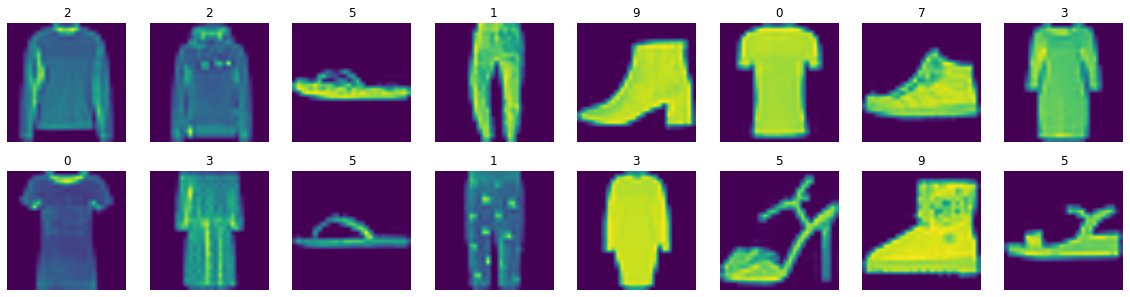

In [7]:
_dl = torch.utils.data.DataLoader(ds_train, shuffle=True, batch_size=16)
sample_batch = next(iter(_dl))
I.wrap(*sample_batch).show(cols=8)

## Defining AlexNet

In [40]:
test_images = sample_batch[0].to(device)
test_images.shape

torch.Size([16, 1, 224, 224])

In [9]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes))
    
    def forward(self, images):
        return self.net(images)
    
_m = AlexNet().to(device)
_m(test_images).shape

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([16, 10])

## Training Loop

In [13]:
def calc_accuracy(images, labels):
    batch_size = len(images)
    pred = model(images)
    pred = pred.detach()

    pred_labels = torch.argmax(pred, dim=-1)
    accuracy = (pred_labels == labels).sum() / batch_size * 100

    return accuracy

In [41]:
def train(epochs=1):
    loss_list = []
    valid_loss_list = []
    accuracy_list = []
    valid_accuracy_list = []

    lp = I.live_plot(2)
    i = 0

    for epoch in range(epochs):
        for batch in tqdm(dl_train):
            i += 1;
            images = batch[0].to(device)
            labels = batch[1].to(device)
            batch_size = len(images)

            optimizer.zero_grad()

            yhat = model(images)
            loss = F.cross_entropy(yhat, labels)

            loss.backward()

            with torch.no_grad():   
                optimizer.step()


        with torch.no_grad():
            _dl = torch.utils.data.DataLoader(ds_train, shuffle=True, batch_size=64)
            sample = next(iter(_dl))
            train_images, train_lables = sample[0].to(device), sample[1].to(device)

            accuracy_list.append(calc_accuracy(train_images, train_lables).cpu().item())
            train_loss = F.cross_entropy(model(train_images), train_lables)
            loss_list.append(train_loss.item())

            _dl = torch.utils.data.DataLoader(ds_valid, shuffle=True, batch_size=64)
            sample = next(iter(_dl))
            valid_images, valid_lables = sample[0].to(device), sample[1].to(device)

            valid_accuracy_list.append(calc_accuracy(valid_images, valid_lables).cpu().item())
            valid_loss = F.cross_entropy(model(valid_images), valid_lables)
            valid_loss_list.append(valid_loss.item())

        lp.plot(0, loss_list, label="train loss")
        lp.plot(0, valid_loss_list, label="valid loss")
        lp.plot(1, accuracy_list, label="train accuracy")
        lp.plot(1, valid_accuracy_list, label="valid accuracy")
        lp.update()

    lp.close()

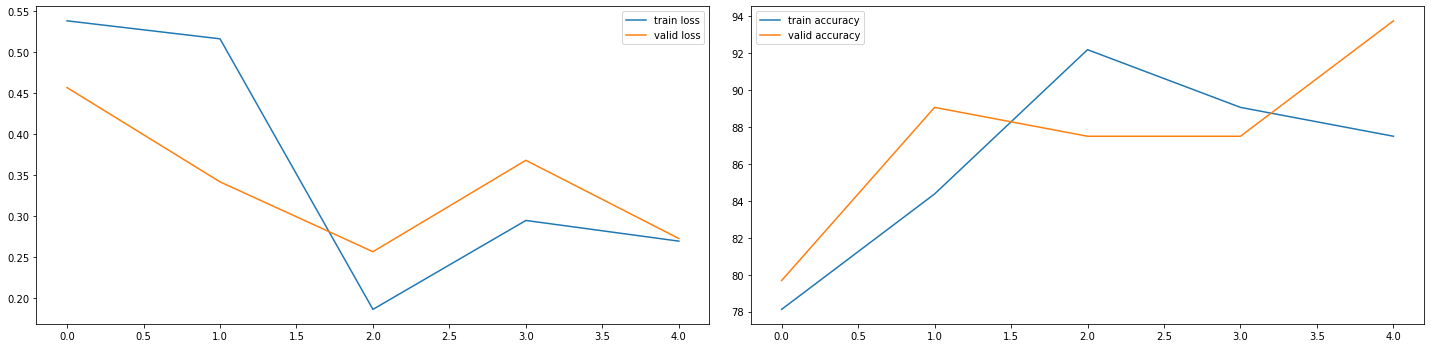

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

In [42]:
bs = 32
lr = 0.01
wd = 0.0005

def init_weights(layer):
    if type(layer) == nn.modules.conv.Conv2d or type(layer) == nn.modules.linear.Linear:
        nn.init.xavier_uniform_(layer.weight)

dl_train = torch.utils.data.DataLoader(ds_train, shuffle=True, batch_size=bs)
model = AlexNet().to(device)
model(test_images) #need to initialize parameters for the lazy
model.apply(init_weights)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
train(5)

In [43]:
def calc_valid_accuracy():
    _dl = torch.utils.data.DataLoader(ds_valid, shuffle=True, batch_size=128)
    accuracy_list = []
    for batch in tqdm(_dl):
        images = batch[0].to(device)
        labels = batch[1].to(device)

        with torch.no_grad():
            accuracy_list.append(calc_accuracy(images, labels))

    return torch.tensor(accuracy_list).mean().item()

calc_valid_accuracy()

  0%|          | 0/469 [00:00<?, ?it/s]

91.08031463623047

**Yeah! It does a better job.**

Anyway, this model is too much for FMnist